## Figure 10

Code to reproduce Figure 10 - superposed epoch analysis for catalytic O3 loss cycles

Data used:
- Ozone loss via catalytic cycles
    - filenames: *_sum_NOx_25km.nc, *_sum_Cl_Br_25km.nc, *_sum_HOx_25km.nc

## Read files

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import ScalarFormatter
import palettable
import cftime

In [22]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'

plt.rc('font', size=13)          # controls default text sizes          
plt.rc('axes', titlesize=13)     # fontsize of the axes title
plt.rc('axes', labelsize=13)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize

## Functions

In [3]:
EARTH_RADIUS = 6371000.0  # m

def estimate_bounds(points, bound_position=0.5):
    diffs = np.diff(points)
    diffs = np.concatenate(([diffs[0]], diffs, [diffs[-1]]))
    lower_bounds = points - diffs[:-1] * bound_position
    upper_bounds = points + diffs[1:] * (1 - bound_position)
    return np.column_stack((lower_bounds, upper_bounds))

def calculate_spherical_area(lat_bounds_rad, lon_bounds_rad, earth_radius):
    radius_sqr = earth_radius ** 2
    lat_bounds = lat_bounds_rad.astype(np.float64)
    lon_bounds = lon_bounds_rad.astype(np.float64)
    
    lat_diff = np.sin(lat_bounds[:, 1]) - np.sin(lat_bounds[:, 0])
    lon_diff = lon_bounds[:, 1] - lon_bounds[:, 0]
    
    areas = radius_sqr * np.outer(lat_diff, lon_diff)
    return np.abs(areas)

def calc_grid_cell_areas(longitudes, latitudes):
    lon_bounds_rad = np.deg2rad(estimate_bounds(longitudes))
    lat_bounds_rad = np.deg2rad(estimate_bounds(latitudes))
    
    areas = calculate_spherical_area(lat_bounds_rad, lon_bounds_rad, EARTH_RADIUS)
    return areas * 10000  # Convert m^2 to cm^2

In [4]:
def calc_cumulative_mean(df):

    conv_factor = 60*60*24*30 * 6.02e23 / 2.69e16 

    temp = df[:,:,0:24,:] #ensemble; time; lat; lon

    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
      
    temp2 = temp * conv_factor / cell_area # convert from flux (moles/s) to DU
    
    weights = np.cos(np.deg2rad(temp2.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp2.weighted(weights)
    all_temp = temp_w.mean(dim=['latitude','longitude'])
    
    all_ens = []
    y=0
    for _ in range(85):
        df_year = all_temp[:,y+9:y+9+6] # sum from October to March
        all_ens.append(df_year.sum(dim='time'))
        y = y + 6
        
    all_ens2 = xr.concat(all_ens, dim='time')

    ens = all_ens2.mean(dim='ensemble')

    return all_ens2, ens

def calc_lat_mean(df):

    conv_factor = 60*60*24*30 * 6.02e23 / 2.69e16 

    temp = df[:,:,24:48,:] 
    
    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
      
    temp2 = temp * conv_factor / cell_area # convert from flux (moles/s) to DU
    
    weights = np.cos(np.deg2rad(temp2.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp2.weighted(weights)
    all_temp = temp_w.mean(dim=['latitude','longitude']) 
    all_ens = all_temp

    ens = all_ens.mean(dim='ensemble')

    return all_ens, ens

def calc_antarc_area(df):
    
    temp = df[:,:,0:24,:]

    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)
    
    total_area = np.sum(cell_area) * 1e-10

    return total_area #km2

def calc_SH_area(df):
    
    temp = df[:,:,24:48,:]

    lon = temp.longitude.values
    lat = temp.latitude.values
    cell_area = calc_grid_cell_areas(lon, lat)

    total_area = np.sum(cell_area) * 1e-10

    return total_area #km2

def calc_ens_mean(df):
    mean_array = np.mean(df, axis = 0)
    return mean_array

In [5]:
def calc_cumulative_list(data, varname):

    if varname == None:

        data_novolc, data_ens_novolc = calc_cumulative_mean(data['novolc'])
        data_volc50_1, data_ens_volc50_1 = calc_cumulative_mean(data['volc50_1'])
        data_volc50_2, data_ens_volc50_2 = calc_cumulative_mean(data['volc50_2'])
        data_volc25, data_ens_volc25 = calc_cumulative_mean(data['volc25'])
        data_volc98, data_ens_volc98 = calc_cumulative_mean(data['volc98'])

    else:
        data_novolc, data_ens_novolc = calc_cumulative_mean(data['novolc'][varname])
        data_volc50_1, data_ens_volc50_1 = calc_cumulative_mean(data['volc50_1'][varname])
        data_volc50_2, data_ens_volc50_2 = calc_cumulative_mean(data['volc50_2'][varname])
        data_volc25, data_ens_volc25 = calc_cumulative_mean(data['volc25'][varname])
        data_volc98, data_ens_volc98 = calc_cumulative_mean(data['volc98'][varname])

    list = [data_volc50_1, data_volc50_2, data_volc25, data_volc98] 
    list_ens = [data_ens_volc50_1, data_ens_volc50_2, data_ens_volc25, data_ens_volc98] 
    novolc_list = data_ens_novolc

    return list, list_ens, novolc_list


def calc_cumulative_list_SH(data, varname):

    if varname == None:

        data_novolc, data_ens_novolc = calc_lat_mean(data['novolc'])
        data_volc50_1, data_ens_volc50_1 = calc_lat_mean(data['volc50_1'])
        data_volc50_2, data_ens_volc50_2 = calc_lat_mean(data['volc50_2'])
        data_volc25, data_ens_volc25 = calc_lat_mean(data['volc25'])
        data_volc98, data_ens_volc98 = calc_lat_mean(data['volc98'])

    else:
        data_novolc, data_ens_novolc = calc_lat_mean(data['novolc'][varname])
        data_volc50_1, data_ens_volc50_1 = calc_lat_mean(data['volc50_1'][varname])
        data_volc50_2, data_ens_volc50_2 = calc_lat_mean(data['volc50_2'][varname])
        data_volc25, data_ens_volc25 = calc_lat_mean(data['volc25'][varname])
        data_volc98, data_ens_volc98 = calc_lat_mean(data['volc98'][varname])

    list = [data_volc50_1, data_volc50_2, data_volc25, data_volc98] 
    list_ens = [data_ens_volc50_1, data_ens_volc50_2, data_ens_volc25, data_ens_volc98] 
    novolc_list = data_ens_novolc

    return list, list_ens, novolc_list

In [6]:
def superposed_epoch(cycles):
    df_novolc = dataframe_novolc[cycles]
    data = data_all[cycles]
    data2 = data_ens[cycles]

    limit = 0.2
    df_eruptions2 = df_eruptions[df_eruptions.Antarc_S_sulfur > limit]
        
    selected_eruptions_year = {'volc50_1':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc50_1'].values),
                            'volc50_2':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc50_2'].values),
                            'volc25':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc25'].values),
                            'volc98':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc98'].values)}


    selected_eruptions_month = {'volc50_1':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc50_1'].values),
                               'volc50_2':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc50_2'].values),
                               'volc25':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc25'].values),
                               'volc98':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc98'].values)}
    
    dict_dataslice = {'volc50_1':{},'volc50_2':{},'volc25': {},'volc98':{}}
    i = 0 
    for scenario in dict_dataslice:
        for ens in range(3):
            df = data[i][:,ens]
            erup_year = selected_eruptions_year[scenario]
            erup_month = selected_eruptions_month[scenario]
            
            output = []
         
            for y in erup_year:
                index = y-2015-1
                dataslice = df[index-2:index+6]
                dataslice_novolc = df_novolc[index-2:index+6]
                mean_before_erup = df[index-2:index].mean() - df_novolc[index-2:index].mean()
    
                anomaly = ((dataslice - dataslice_novolc).values - mean_before_erup.values)
                output.append(anomaly)
    
            dict_dataslice[scenario][ens] = output
        i = i+1
    
    
    dict_ens_dataslice = {'volc50_1':{},'volc50_2':{},'volc25': {},'volc98':{}}
    
    i = 0 
    for scenario in dict_ens_dataslice:
        df = data2[i][:]
        erup_year = selected_eruptions_year[scenario]
        erup_month = selected_eruptions_month[scenario]
        output = []
         
        for y in erup_year:
            index = y-2015-1
            dataslice = df[index-2:index+6]
            dataslice_novolc = df_novolc[index-2:index+6]
            mean_before_erup = df[index-2:index].mean() - df_novolc[index-2:index].mean()
    
            anomaly = ((dataslice - dataslice_novolc).values - mean_before_erup.values)
            output.append(anomaly)
    
        dict_ens_dataslice[scenario] = output
        i = i+1


    array_concat =  dict_ens_dataslice['volc50_1'] + dict_ens_dataslice['volc50_2'] + dict_ens_dataslice['volc25'] + dict_ens_dataslice['volc98']

    ens_mean = calc_ens_mean(array_concat)
    
    
    all_array_concat = []
    for item in dict_dataslice:
        temp = dict_dataslice[item][0] + dict_dataslice[item][1] + dict_dataslice[item][2]
        all_array_concat = all_array_concat + temp
    
    mean = np.mean(all_array_concat, axis = 0)
    std = np.std(all_array_concat, axis = 0)
    q3 = np.quantile(all_array_concat, 0.75, axis = 0)
    q1 = np.quantile(all_array_concat, 0.25, axis = 0)


    #############

    min_mean = []
    max_mean = []
    for i in range(len(array_concat)):
        temp_mean = min(array_concat[i][2], array_concat[i][3])
        temp_mean2 = max(array_concat[i][2], array_concat[i][3])
        min_mean.append(temp_mean)
        max_mean.append(temp_mean2)

    return min_mean, max_mean, mean, q1, q3


In [7]:
def superposed_epoch_SH(cycles):

    df_novolc = dataframe_SH_novolc[cycles]
    data = data_SH_all[cycles]
    data2 = data_SH_ens[cycles]

    limit = 0.2
    df_eruptions2 = df_eruptions[df_eruptions.Antarc_S_sulfur > limit]
        
    selected_eruptions_year = {'volc50_1':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc50_1'].values),
                            'volc50_2':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc50_2'].values),
                            'volc25':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc25'].values),
                            'volc98':list(df_eruptions2.Year[df_eruptions2.scenario == 'volc98'].values)}
    
    selected_eruptions_month = {'volc50_1':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc50_1'].values),
                               'volc50_2':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc50_2'].values),
                               'volc25':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc25'].values),
                               'volc98':list(df_eruptions2.Month[df_eruptions2.scenario == 'volc98'].values)}
    
    dict_dataslice = {'volc50_1':{},'volc50_2':{},'volc25': {},'volc98':{}}

    i = 0 
    for scenario in dict_dataslice:
        for ens in range(3):
            df = data[i][ens,:]
            erup_year = selected_eruptions_year[scenario]
            erup_month = selected_eruptions_month[scenario]
            
            output = []
    
            for (y,m) in zip(erup_year, erup_month):
                # Calculate cumulative O3 loss for 12 months since eruption month
                all_ens = []
                novolc_ens = []
                for _ in range(85):
                    df_sum = df[m-1:m-1+12].sum(dim='time') # sum from eruption month for 12 months, skip first year
                    all_ens.append(df_sum)
    
                    df_sum_novolc = df_novolc[m-1:m-1+12].sum(dim='time') # sum from eruption month for 12 months, skip first year
                    novolc_ens.append(df_sum_novolc)
                    m = m + 12
                df_all = xr.concat(all_ens, dim='time')
                df_novolc_cumu = xr.concat(novolc_ens, dim='time')
                
                index = y-2015
                dataslice = df_all[index-2:index+6]
                dataslice_novolc = df_novolc_cumu[index-2:index+6]
                
                mean_before_erup = df_all[index-2:index].mean() - df_novolc_cumu[index-2:index].mean()
    
                anomaly = ((dataslice - dataslice_novolc).values - mean_before_erup.values)
    
                output.append(anomaly)
    
            dict_dataslice[scenario][ens] = output
        i = i+1


    dict_ens_dataslice = {'volc50_1':{},'volc50_2':{},'volc25': {},'volc98':{}}
    
    i = 0 
    for scenario in dict_ens_dataslice:
        df = data2[i][:]
        erup_year = selected_eruptions_year[scenario]
        erup_month = selected_eruptions_month[scenario]
        output = []
         
        for (y,m) in zip(erup_year, erup_month):
            # Calculate cumulative O3 loss for 12 months since eruption month
            all_ens = []
            novolc_ens = []
            for _ in range(85):
                df_sum = df[m-1:m-1+12].sum(dim='time') # sum from eruption month for 12 months, skip first year
                all_ens.append(df_sum)
    
                df_sum_novolc = df_novolc[m-1:m-1+12].sum(dim='time') # sum from eruption month for 12 months, skip first year
                novolc_ens.append(df_sum_novolc)
                m = m + 12
            df_all = xr.concat(all_ens, dim='time')
            df_novolc_cumu = xr.concat(novolc_ens, dim='time')
            
            index = y-2015
            dataslice = df_all[index-2:index+6]
            dataslice_novolc = df_novolc_cumu[index-2:index+6]
            mean_before_erup = df_all[index-2:index].mean() - df_novolc_cumu[index-2:index].mean()
    
            anomaly = ((dataslice - dataslice_novolc).values - mean_before_erup.values)
            output.append(anomaly)
    
        dict_ens_dataslice[scenario] = output
        i = i+1	


    array_concat =  dict_ens_dataslice['volc50_1'] + dict_ens_dataslice['volc50_2'] + dict_ens_dataslice['volc25'] + dict_ens_dataslice['volc98']

    ens_mean = calc_ens_mean(array_concat)
    
    all_array_concat = []
    for item in dict_dataslice:
        temp = dict_dataslice[item][0] + dict_dataslice[item][1] + dict_dataslice[item][2]
        all_array_concat = all_array_concat + temp
    
    mean = np.mean(all_array_concat, axis = 0)
    std = np.std(all_array_concat, axis = 0)
    q3 = np.quantile(all_array_concat, 0.75, axis = 0)
    q1 = np.quantile(all_array_concat, 0.25, axis = 0)


    #############

    min_mean = []
    max_mean = []
    for i in range(len(array_concat)):
        temp_mean = min(array_concat[i][2], array_concat[i][3])
        temp_mean2 = max(array_concat[i][2], array_concat[i][3])
        min_mean.append(temp_mean)
        max_mean.append(temp_mean2)

    return min_mean, max_mean, mean, q1, q3


In [8]:
def plot_composite(data, quantile1, quantile2, title, color, ax):

    year_index = [-2,-1,0,1,2,3,4,5]
    ax.plot(year_index, ens_mean, color = color, lw = 4)
    ax.fill_between(year_index, q1, q3, color = 'lightgrey', alpha = 0.5)

    ax.axvline(x = 0, color = 'k', ls = 'dotted', lw = 1)
    ax.axhline(y = 0, color = 'k', ls = 'dotted', lw = 1)
    
    ax.set_xlim(-2,5)
    ax.set_xlabel('Year since eruption', fontsize = 14)
    ax.set_ylim(-10,15)
    ax.set_ylabel('Ozone loss (DU)', fontsize = 14)

    ax.set_title(title, loc = 'right', fontsize = 14)

In [9]:
def plot_peak_ozone_response(data_antarc, data_SH, cycle, ax):


    cmap = ListedColormap(palettable.scientific.sequential.LaJolla_13.mpl_colors)

    ax.axhline(0, color = 'grey', lw = 1)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    
    norm = mcolors.LogNorm(vmin=0.5, vmax=10)
    
    norm_mean_Antarc = data_antarc/Antar_S_sulfur/antarc_area
    norm_mean_SH = data_SH/SH_S_sulfur/SH_area
    
    scatter = ax.scatter(erup_year, norm_mean_Antarc, s = 200, c = Antar_S_sulfur, marker = 'o',
                ec ='k', cmap = cmap, norm=norm, label = 'Antarctica')
    
    scatter = ax.scatter(erup_year, norm_mean_SH, s = 200, c = SH_S_sulfur, marker = '^',
                ec ='k', cmap = cmap, norm=norm, label = 'SH mid-latitudes')
                          
    ax.set_ylabel('DU / Tg * km$^2$', fontsize = 14)
    ax.set_xlabel('Eruption year', fontsize = 14)
    ax.set_xlim(2015,2100)
    ax.set_ylim(-6e-7,6e-7)
    ax.set_title('Peak ozone response to '+cycle+ ' cycles', loc='right', fontsize = 14)
    

## Plot Figure 10a

In [10]:
os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/ozone_catalytic_cycles/sum_cycles/')

ssp370_run = {'novolc': [],'volc50_1': [],'volc50_2': [],'volc98': [],'volc25': []}

NOx_all = {}
ClOx_all = {}
HOx_all = {}
cycle_all = {}

for idx in ssp370_run:

    NOx_all[idx] = xr.open_dataset('_'+idx+'_sum_NOx_25km.nc')
    ClOx_all[idx] = xr.open_dataset('_'+idx+'_sum_Cl_Br_25km.nc')
    HOx_all[idx] = xr.open_dataset('_'+idx+'_sum_HOx_25km.nc')
    cycle_all[idx] = NOx_all[idx].m01s50i117 + ClOx_all[idx].__xarray_dataarray_variable__ + HOx_all[idx].__xarray_dataarray_variable__

    

In [11]:
NOx_SH = {}
ClOx_SH = {}
HOx_SH = {}
cycle_SH = {}

for idx in ssp370_run:

    NOx_SH[idx] = xr.open_dataset('_'+idx+'_sum_NOx_25km_allmonths.nc')
    ClOx_SH[idx] = xr.open_dataset('_'+idx+'_sum_Cl_Br_25km_allmonths.nc')
    HOx_SH[idx] = xr.open_dataset('_'+idx+'_sum_HOx_25km_allmonths.nc')
    cycle_SH[idx] = NOx_SH[idx].m01s50i117 + ClOx_SH[idx].__xarray_dataarray_variable__ + HOx_SH[idx].__xarray_dataarray_variable__

In [12]:
# Read eruptions for sulfur burden
df_eruptions = pd.read_csv('/home/users/mmc70/Notebooks/Ozone_analysis/eruptions_relevant_for_ozone.csv')

limit = 0.2
Antar_S_sulfur = df_eruptions.Antarc_S_sulfur[df_eruptions.Antarc_S_sulfur > limit]
SH_S_sulfur = df_eruptions.SH_S_sulfur[df_eruptions.Antarc_S_sulfur > limit]
Total_S_sulfur = df_eruptions.SO2[df_eruptions.Antarc_S_sulfur > limit]
erup_year = df_eruptions.Year[df_eruptions.Antarc_S_sulfur > limit]

# Area for normalisation
antarc_area = calc_antarc_area(cycle_all['novolc'])
SH_area = calc_SH_area(cycle_SH['novolc'])

In [13]:
list_all, list_ens_all, novolc_list_all = calc_cumulative_list(cycle_all, None)
list_NOx, list_ens_NOx, novolc_list_NOx = calc_cumulative_list(NOx_all, 'm01s50i117')
list_halo, list_ens_halo, novolc_list_halo = calc_cumulative_list(ClOx_all, '__xarray_dataarray_variable__')
list_HOx, list_ens_HOx, novolc_list_HOx = calc_cumulative_list(HOx_all, '__xarray_dataarray_variable__')

data_all = {'halogen': list_halo,'HOx':list_HOx,'all':list_all,'NOx':list_NOx}
data_ens = {'halogen': list_ens_halo,'HOx':list_ens_HOx,'all':list_ens_all,'NOx':list_ens_NOx}
dataframe_novolc = {'all': novolc_list_all,'NOx': novolc_list_NOx,'halogen':novolc_list_halo,'HOx': novolc_list_HOx}

In [14]:
list_all_SH, list_ens_all_SH, novolc_list_all_SH = calc_cumulative_list_SH(cycle_SH, None)
list_NOx_SH, list_ens_NOx_SH, novolc_list_NOx_SH = calc_cumulative_list_SH(NOx_SH, 'm01s50i117')
list_halo_SH, list_ens_halo_SH, novolc_list_halo_SH = calc_cumulative_list_SH(ClOx_SH, '__xarray_dataarray_variable__')
list_HOx_SH, list_ens_HOx_SH, novolc_list_HOx_SH = calc_cumulative_list_SH(HOx_SH, '__xarray_dataarray_variable__')

data_SH_all = {'halogen': list_halo_SH,'HOx':list_HOx_SH,'all':list_all_SH,'NOx':list_NOx_SH}
data_SH_ens = {'halogen': list_ens_halo,'HOx':list_ens_HOx_SH,'all':list_ens_all_SH,'NOx':list_ens_NOx_SH}
dataframe_SH_novolc = {'all': novolc_list_all_SH,'NOx': novolc_list_NOx_SH,'halogen':novolc_list_halo_SH,'HOx': novolc_list_HOx_SH}

Text(-3.5, 20, 'Ozone loss over Antarctica')

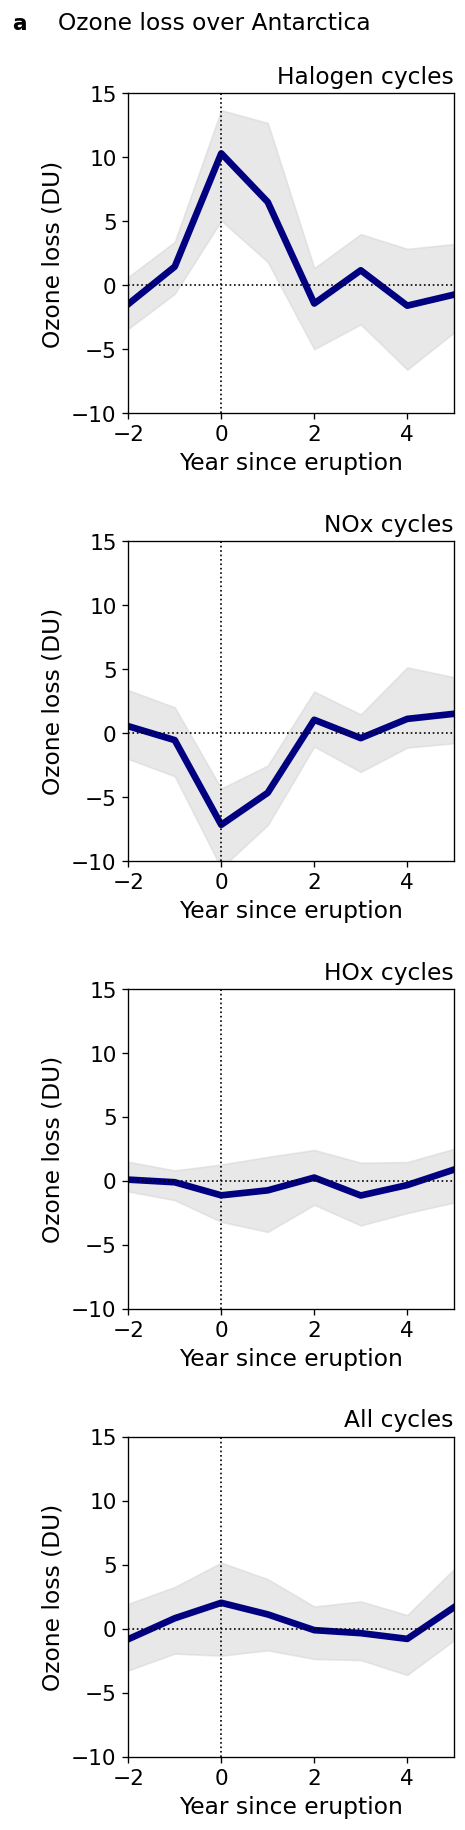

In [15]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(3.5, 18),dpi=120, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})


_, _, ens_mean, q1, q3 = superposed_epoch('halogen')
plot_composite(ens_mean, q1, q3, 'Halogen cycles', 'navy', ax=ax1)

_, _, ens_mean, q1, q3 = superposed_epoch('NOx')
plot_composite(ens_mean, q1, q3, 'NOx cycles', 'navy', ax=ax2)

_, _, ens_mean, q1, q3 = superposed_epoch('HOx')
plot_composite(ens_mean, q1, q3, 'HOx cycles', 'navy', ax=ax3)

_, _, ens_mean, q1, q3 = superposed_epoch('all')
plot_composite(ens_mean, q1, q3, 'All cycles', 'navy', ax=ax4)

ax1.text(-4.5, 20, 'a', weight='bold')
ax1.text(-3.5, 20, 'Ozone loss over Antarctica', fontsize = 14)

Text(-3.5, 20, 'Ozone loss over SH mid-latitudes')

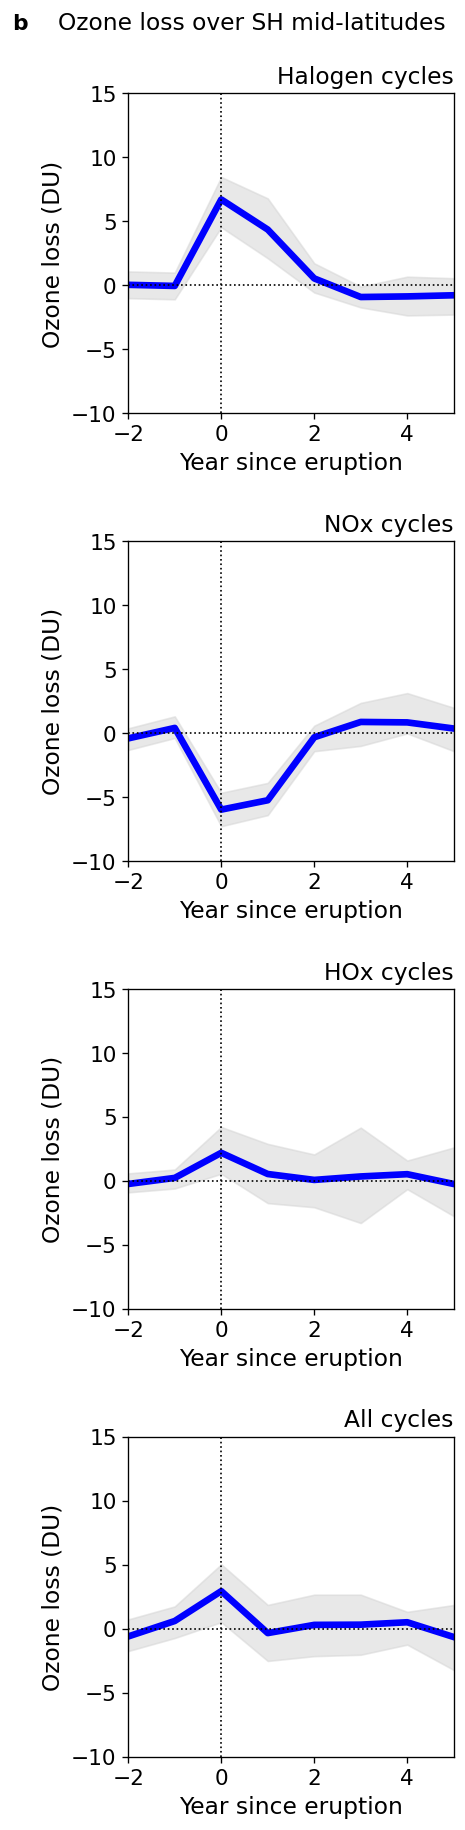

In [16]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(3.5, 18),dpi=120, gridspec_kw={'hspace': 0.4, 'wspace': 0.4})


_, _, ens_mean, q1, q3 = superposed_epoch_SH('halogen')
plot_composite(ens_mean, q1, q3, 'Halogen cycles', 'blue', ax=ax1)

_, _, ens_mean, q1, q3 = superposed_epoch_SH('NOx')
plot_composite(ens_mean, q1, q3, 'NOx cycles', 'blue', ax=ax2)

_, _, ens_mean, q1, q3 = superposed_epoch_SH('HOx')
plot_composite(ens_mean, q1, q3, 'HOx cycles', 'blue', ax=ax3)

_, _, ens_mean, q1, q3 = superposed_epoch_SH('all')
plot_composite(ens_mean, q1, q3, 'All cycles', 'blue', ax=ax4)

ax1.text(-4.5, 20, 'b', weight='bold')
ax1.text(-3.5, 20, 'Ozone loss over SH mid-latitudes', fontsize = 14)

## Plot Figure 10b

In [17]:
# output peak ozone responses for each cycle
min_antarc_halo, max_antarc_halo, _, _, _ = superposed_epoch('halogen')
min_SH_halo, max_SH_halo, _, _, _ = superposed_epoch_SH('halogen')

min_antarc_NOx, max_antarc_NOx, _, _, _ = superposed_epoch('NOx')
min_SH_NOx, max_antarc_NOx, _, _, _ = superposed_epoch_SH('NOx')

min_antarc_HOx, max_antarc_HOx, _, _, _ = superposed_epoch('HOx')
min_SH_HOx, max_SH_HOx, _, _, _ = superposed_epoch_SH('HOx')

# Sum the response for halogen, NOx and HOx for the overall response to all cycles
max_antarc_all = []
max_SH_all = []
for i in range(len(max_antarc_halo)):
    max_antarc_all.append(max_antarc_halo[i] + min_antarc_NOx[i] + max_antarc_HOx[i])
    max_SH_all.append(max_SH_halo[i] + min_SH_NOx[i] + max_SH_HOx[i])


/tmp/ipykernel_12415/721385061.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(2015, 8.3e-07, 'Peak ozone responses over Antarctica and SH mid-latitudes')

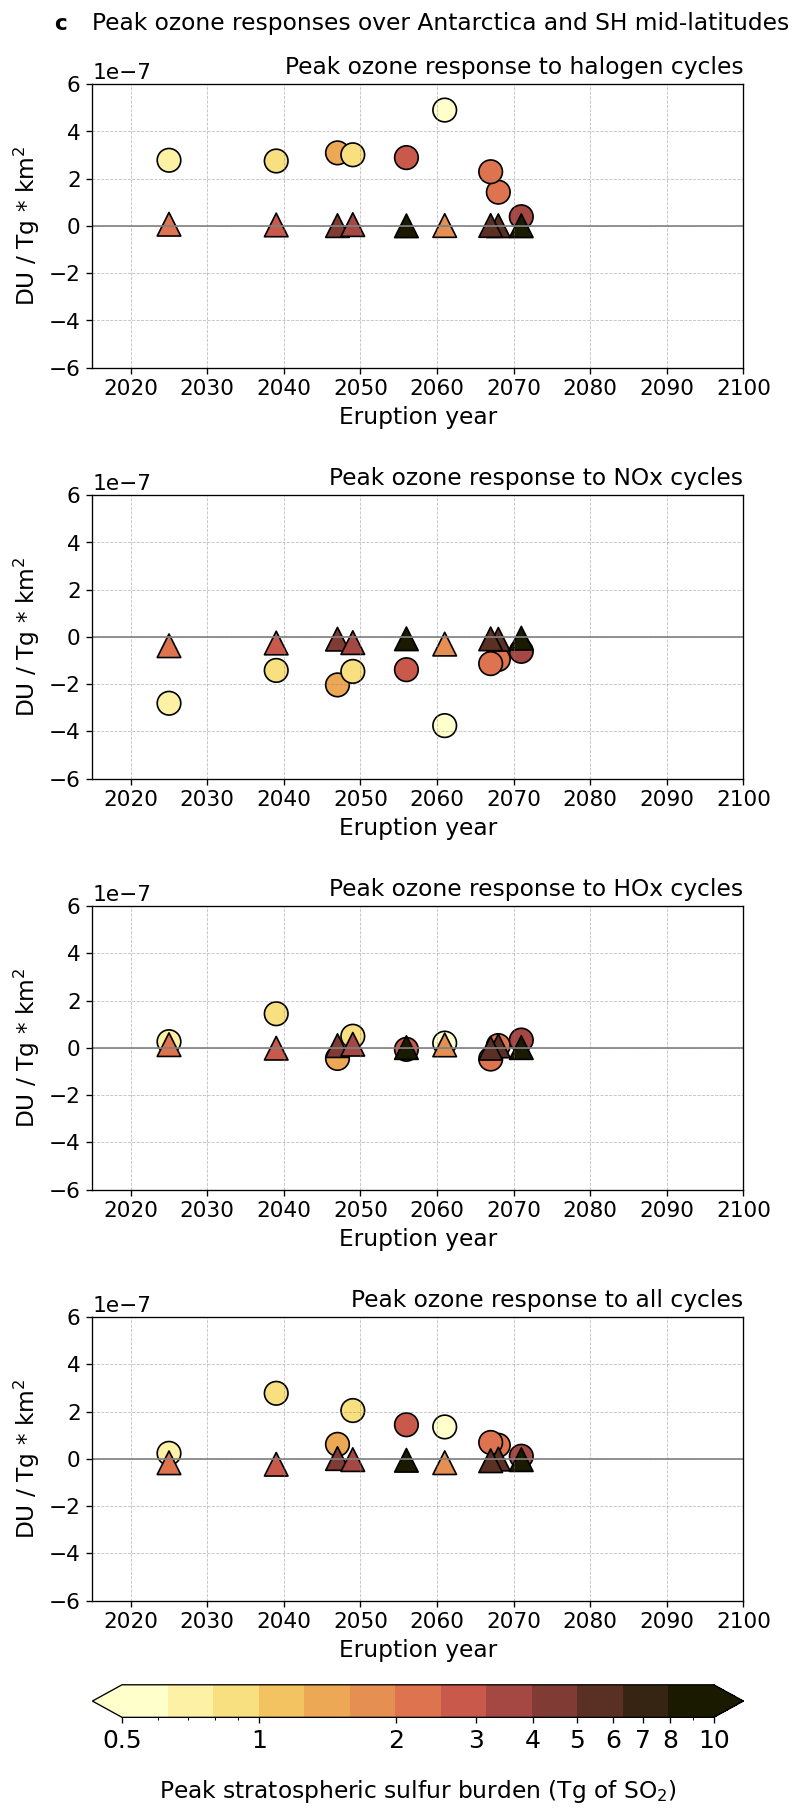

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7, 18),dpi=120, gridspec_kw={'hspace': 0.45, 'wspace': 0.3})

scatter1 = plot_peak_ozone_response(max_antarc_halo, max_SH_halo, 'halogen', ax1)
scatter2 = plot_peak_ozone_response(min_antarc_NOx, min_SH_NOx, 'NOx', ax2)
scatter3 = plot_peak_ozone_response(max_antarc_HOx, max_SH_HOx, 'HOx', ax3)
scatter4 = plot_peak_ozone_response(max_antarc_all, max_SH_all, 'all', ax4)

plt.tight_layout()
fig.subplots_adjust(bottom=0.1, hspace=0.3)

cmap = ListedColormap(palettable.scientific.sequential.LaJolla_13.mpl_colors)
norm = mcolors.LogNorm(vmin=0.5, vmax=10)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

cbar = fig.colorbar(sm, ax=[ax1, ax2, ax3, ax4], orientation = "horizontal", extend = 'both', fraction = 0.05, pad = 0.05)
cbar.ax.tick_params(labelsize = 15)
cbar.outline.set_visible(True)
cbar.set_label('Peak stratospheric sulfur burden (Tg of SO$_2$)', fontsize = 14, labelpad = 15)

ticks = [0.5,1,2,3,4,5,6,7,8,10]
tick_labels = [str(t) for t in ticks]
cbar.set_ticks(ticks)
cbar.set_ticklabels(tick_labels)

ax1.text(2010, 8.3e-7, 'c', weight='bold')
ax1.text(2015, 8.3e-7, 'Peak ozone responses over Antarctica and SH mid-latitudes', fontsize = 14)
